In [1]:
!pip install csbdeep
!pip install spectral

     |████████████████████████████████| 71kB 4.1MB/s 
     |████████████████████████████████| 133kB 9.4MB/s 
     |████████████████████████████████| 18.1MB 195kB/s 
     |████████████████████████████████| 194kB 5.5MB/s 


In [2]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [3]:
!nvidia-smi

Tue Apr 28 14:40:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE
from csbdeep.data import RawData, create_patches
from keras import backend as K
from keras.backend import relu

Using TensorFlow backend.


In [ ]:
import os
base_path = os.path.abspath('')

In [5]:
(X,Y), _, axes = load_training_data(base_path + '/patches/my_training_data_east_64_2000_max.npz')
(X_val,Y_val), _, _ = load_training_data(base_path + '/patches/my_training_data_west_64_2000_max.npz')

factor = 800  #save for restoration
clip = np.max(X) #save for restoration

Y = Y * factor
Y_val = Y_val * factor
print(np.max(X), np.max(Y))

2000.0 50400.0


In [0]:
#X, Y, X_val, Y_val = X.astype('float16'), Y.astype('float16'), X_val.astype('float16'), Y_val.astype('float16')

In [0]:
#augment data
def fliplr(X):
  for x in X:
    yield np.fliplr(x)

def flipud(X):
  for x in X:
    yield np.flipud(x)

def flip90(X):
  for x in X:
    yield np.rot90(x)

def flip180(X):
  for x in X:
    yield np.rot90(x, 2)

def flip270(X):
  for x in X:
    yield np.rot90(x, 3)

def same(X):
  for x in X:
    yield x

transforms_x = [fliplr(X), flipud(X), flip90(X), flip180(X), flip270(X), same(X)]
transforms_y = [fliplr(Y), flipud(Y), flip90(Y), flip180(Y), flip270(Y), same(Y)]

In [8]:
X_transformed_l = [] 
Y_transformed_l = []

for transform in transforms_x:
  for x in transform:
    X_transformed_l.append(x)

X_transformed = np.array(X_transformed_l)
X_transformed_l = None
X = None

for transform in transforms_y:
  for y in transform:
    Y_transformed_l.append(y)

Y_transformed = np.array(Y_transformed_l)
Y_transformed_l = None
Y = None

print(X_transformed.shape, Y_transformed.shape)

(120000, 64, 64, 1) (120000, 64, 64, 1)


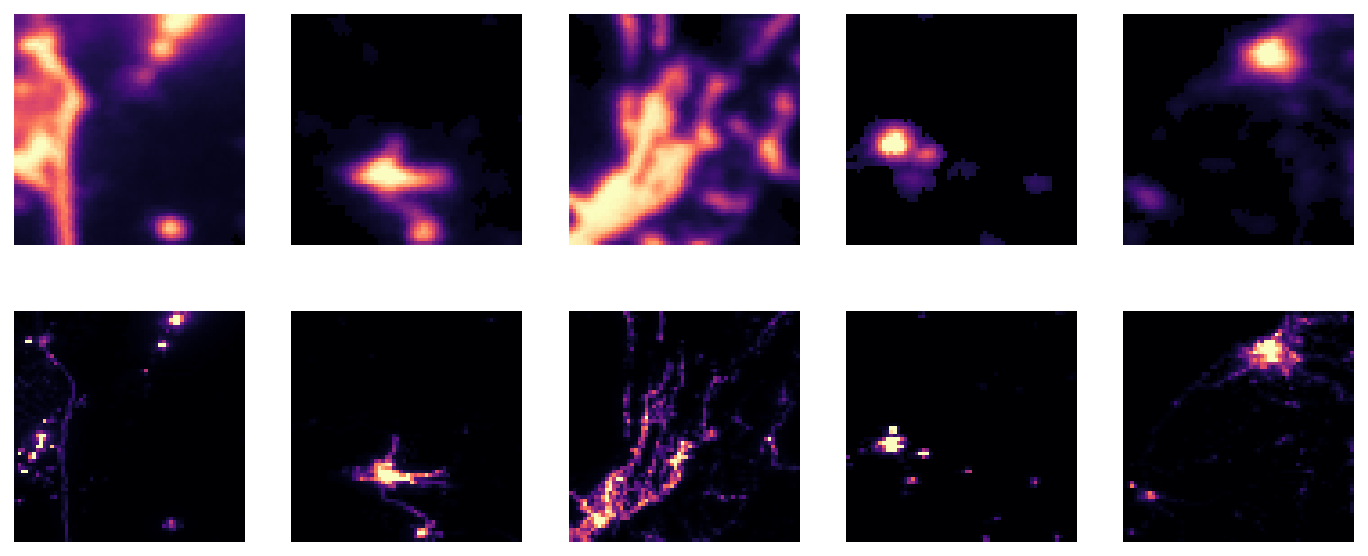

In [9]:
plt.figure(figsize=(12,5))
plot_some(Y_transformed[5000:5005],X_transformed[5000:5005], pmax=99.5)

In [10]:
from sys import getsizeof
getsizeof(Y_transformed) / (1024 * 1024)

1875.0001373291016

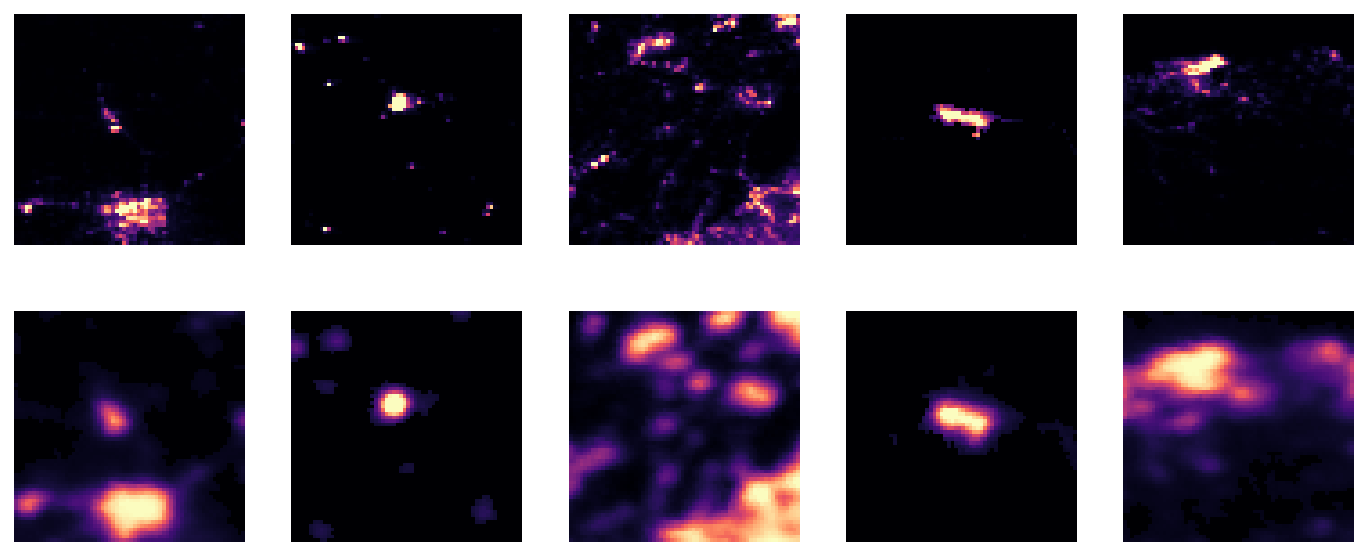

In [11]:
im_num = 20
plt.figure(figsize=(12,5))
plot_some(X_val[im_num:im_num+5],Y_val[im_num:im_num+5], pmax=99.5)

In [0]:
from keras import backend as K
from keras.layers import Activation
from keras.losses import mean_squared_error

def relu_advanced(x):
    return K.relu(x, max_value=factor * 63.0)

def internal_activation(x):
  return K.relu(x, max_value=None)

# def my_error(Y_true, Y_pred):
#   power = 3/2
#   return np.square(np.mean(np.power(Y_true, power) - np.power(Y_pred, power), axis=-1))

from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({'linear': Activation(relu_advanced)})
get_custom_objects().update({'relu': Activation(internal_activation)})

In [13]:
get_custom_objects()

{'linear': <keras.layers.core.Activation at 0x7faff0969a20>,
 'relu': <keras.layers.core.Activation at 0x7faff49309b0>}

In [0]:
model_number = 23 #save for restoration

In [0]:
config = Config(axes, unet_n_depth=5, train_epochs=5, train_steps_per_epoch=4000, train_batch_size=32, unet_last_activation='linear', unet_n_first=64, train_loss='mae')
model = CARE(config, 'my_model_long_{}'.format(model_number), basedir=base_path + '/models')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



/usr/local/lib/python3.6/dist-packages/csbdeep/models/base_model.py:134: UserWarning: output path for model already exists, files may be overwritten: /content/drive/My Drive/Diploma/models/my_model_long_23
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


In [0]:
history = model.train(X_transformed, Y_transformed, validation_data=(X_val,Y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/csbdeep/models/care_standard.py:153: UserWarning: small number of validation images (only 0.4% of all images)
  warnings.warn("small number of validation images (only %.1f%% of all images)" % (100*frac_val))



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/5
4000/4000 [==============================] - 1538s 384ms/step - loss: 1202.6292 - mse: 7728225.0000 - mae: 1202.6293 - val_loss: 947.9567 - val_mse: 4456809.5000 - val_mae: 947.9567

Epoch 2/5
4000/4000 [==============================] - 1527s 382ms/step - loss: 980.3052 - mse: 3972400.2500 - mae: 980.3069 - val_loss: 867.7763 - val_mse: 3584772.2500 - val_mae: 867.7762
Epoch 3/5
4000/4000 [==============================] - 1527s 382ms/step - loss: 951.2960 - mse: 3782058.0000 - mae: 951.2950 - val_loss: 853.0128 - val_mse: 3548372.0000 - val_mae: 853.0128
Epoch 4/5
4000/4000 [==============================] - 1530

In [0]:
Y_val.shape

(500, 64, 64, 1)

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


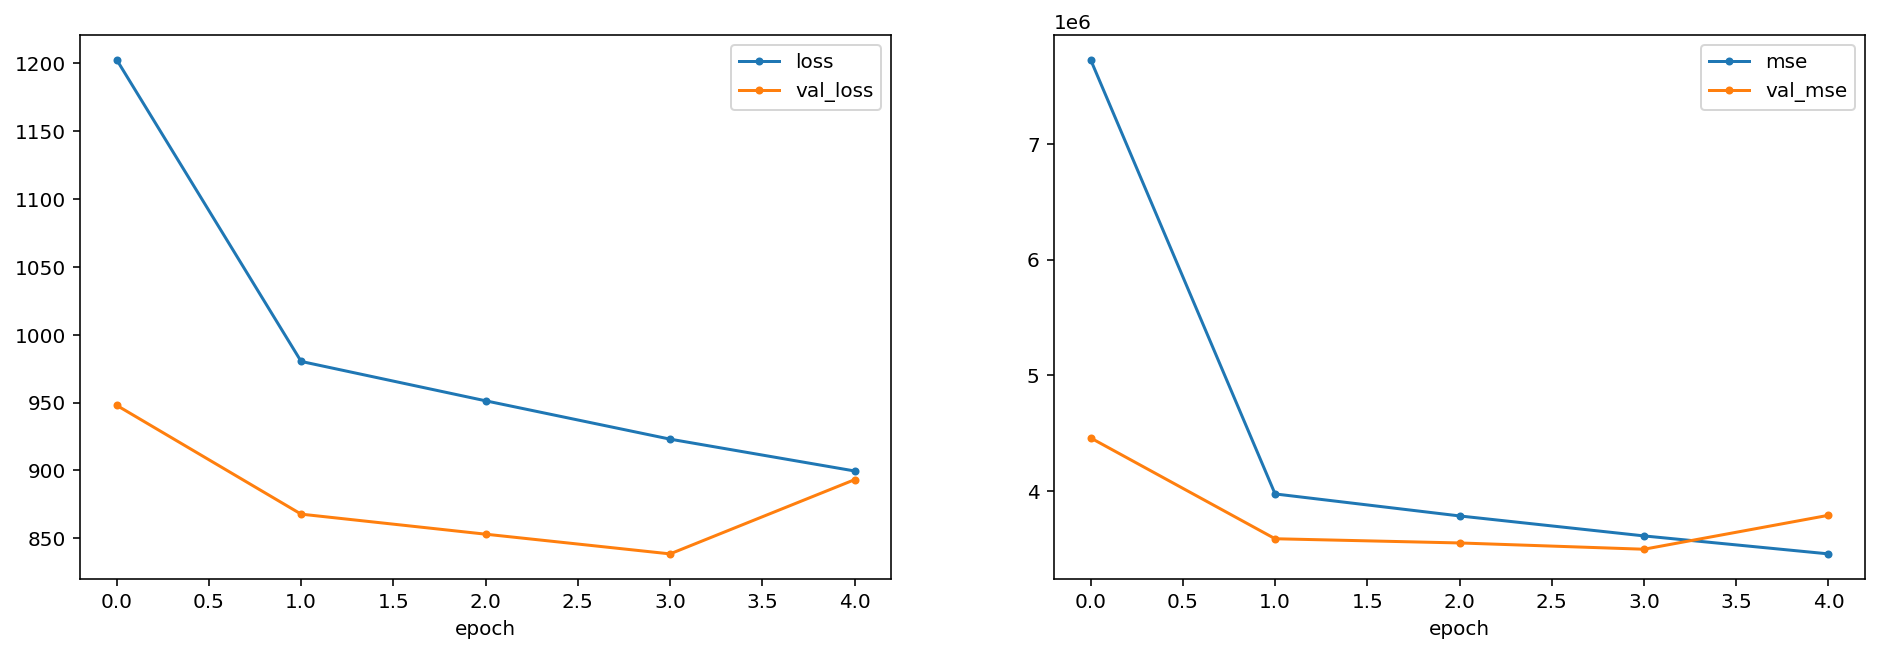

In [0]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse']);

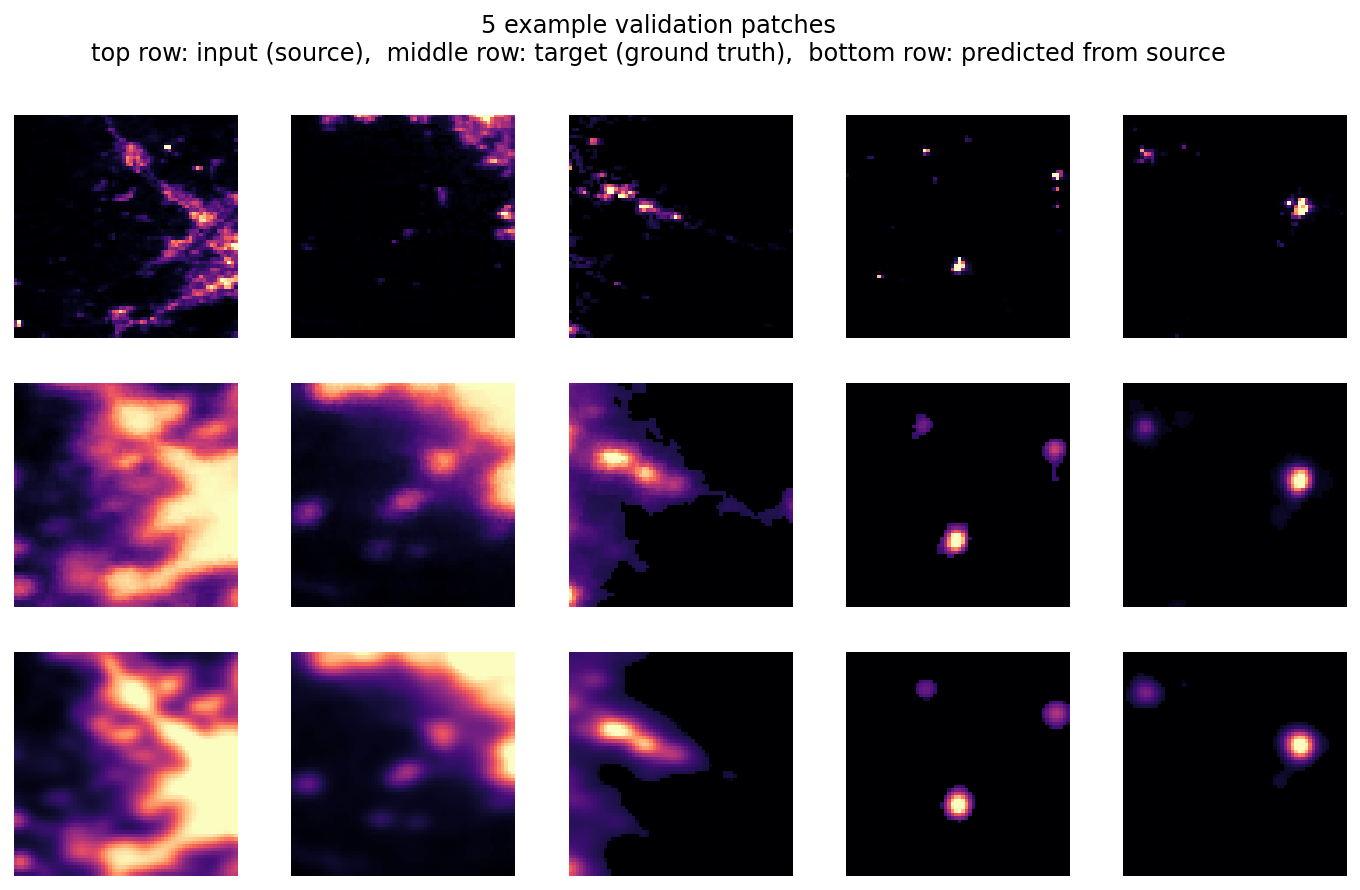

In [0]:
im_num = 160
plt.figure(figsize=(12,7))
_P = model.keras_model.predict(X_val[im_num:im_num+5])
plot_some(X_val[im_num:im_num+5],Y_val[im_num:im_num+5],_P,pmax=99.8)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');

In [0]:
import pandas as pd
# if you want to save parameters needed for further restoration change save_params = True, warning if model is already in loaded DataFrame, its values will be overwritten
path_to_params = base_path + '/Data/parameters_for_restoration.pkl'
save_params = True
if save_params:
  parameters = pd.DataFrame(data = [[model_number, factor, clip]], columns = ['model_number', 'factor', 'clip'])
  try:
    old_params = pd.read_pickle(path_to_params)
    if np.any(old_params.loc[:, 'model_number'] == model_number):
      old_params.loc[old_params.loc[:, 'model_number'] == model_number] = parameters.loc[:,:]
      old_params.to_pickle(path_to_params)
    else:
      parameters = pd.concat([old_params, parameters])
      parameters.to_pickle(path_to_params)
  except:
    parameters.to_pickle(path_to_params)
  print(pd.read_pickle(path_to_params))

3 и 4 и 5, 6, 7, 8, 9, 10 успешны не трогать их, 5, 2 слоя натренен более правильно, 6 3 внутренних слоя, 200x200, 7 4 layers 192x192, 8 3 слоя 512х512, 9 4 слоя 512х512, 10 3 слоя 128





### Итак, модель 12 сделана без нормализаций с кастомным релу слоем. 2 слоя, 128х128, восточное полушарие, batch size 32, n_first 32

### Модель 13 сделана без нормализаций с кастомным релу слоем. 3 слоя, 128х128, восточное полушарие, batch size 32, n_first 32

### Модель 16 сделана с ограничением 1000 на инпут с кастомным релу слоем аут 63, внутри без ограничений. 5 слоёв, 128х128, восточное полушарие, batch size 32, n_first 32

### Модель 18 сделана с ограничением 1000 на инпут, кастомный релу аут 6300 Internal no limit, 3 слоя, 128х128, восточное полушарие, batch size 32, n_first 64, получилось збс, mse

### Модель 19 сделана с ограничением 1000 на инпут, кастомный релу аут 6300 Internal no limit, 3 слоя, 128х128, восточное полушарие, batch size 32, n_first 64, получилось ещё более /збс, mae

### Модель 20 сделана с ограничением 2000 на инпут, кастомный релу аут 12600 Internal no limit, 3 слоя, 128х128, восточное полушарие, batch size 32, n_first 64, получилось ещё более /збс, mae

### Модель 21 сделана с ограничением 2000 на инпут, кастомный релу аут 25200 Internal no limit, 4 слоя, 128х128, восточное полушарие, batch size 32, n_first 64, получилось ещё более /збс, mae

### Модель 22 сделана с ограничением 2000 на инпут, кастомный релу аут 50400 Internal no limit, 5 слёв, 128х128, восточное полушарие, batch size 32, n_first 64, получилось ещё более /збс, mae